In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")
colors = sns.color_palette("muted", 8)

# Load the CSV files
errors_df = pd.read_csv('data/errors.csv')
exec_times_df = pd.read_csv('data/execution_times.csv')

# Extract data from the CSV files
points = errors_df['Points']
threads = [int(col.split('_')[1]) for col in errors_df.columns[1:]]

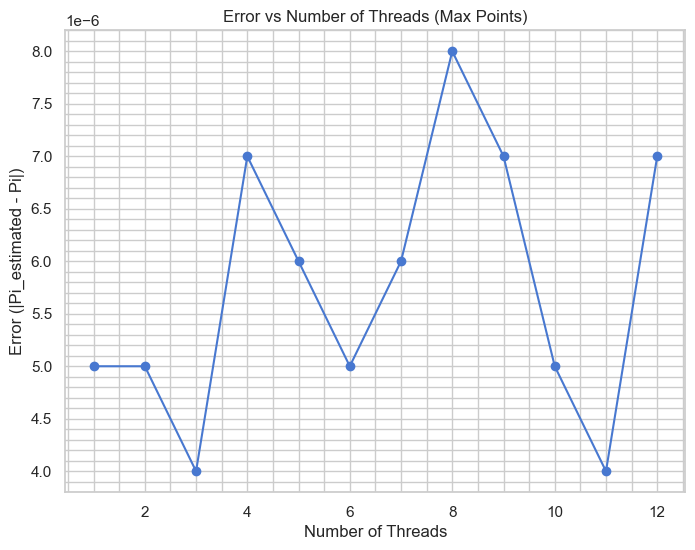

In [2]:
# Plot 1: Error vs Number of Threads (Max Points)
max_points_error = errors_df.iloc[-1, 1:]

plt.figure(figsize=(8, 6))
plt.plot(threads, max_points_error, marker='o', linestyle='-', color=colors[0])
plt.xlabel('Number of Threads')
plt.ylabel('Error (|Pi_estimated - Pi|)')
plt.title('Error vs Number of Threads (Max Points)')
plt.grid(True, which='both', axis='both')
plt.minorticks_on()
plt.show()

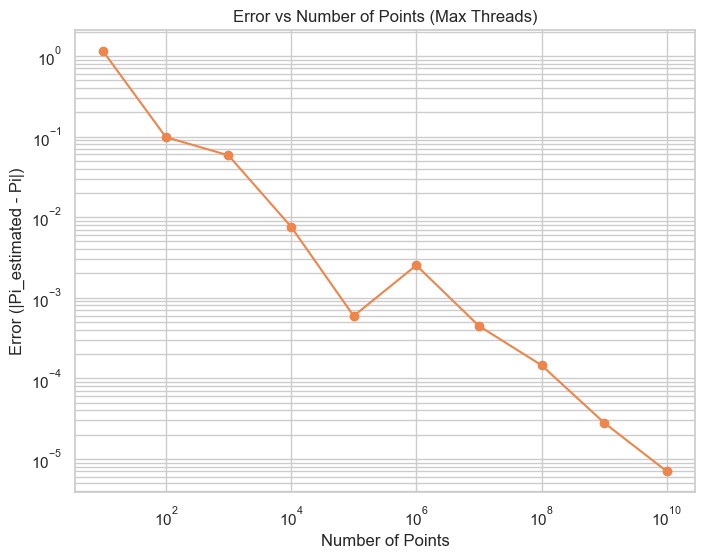

In [3]:
# Plot 2a: Error vs Number of Points (Max Threads)
max_threads_error = errors_df[errors_df.columns[-1]]

plt.figure(figsize=(8, 6))
plt.plot(points, max_threads_error, marker='o', linestyle='-', color=colors[1])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Points')
plt.ylabel('Error (|Pi_estimated - Pi|)')
plt.title('Error vs Number of Points (Max Threads)')
plt.grid(True, which='both', axis='both')
plt.minorticks_on()
plt.show()

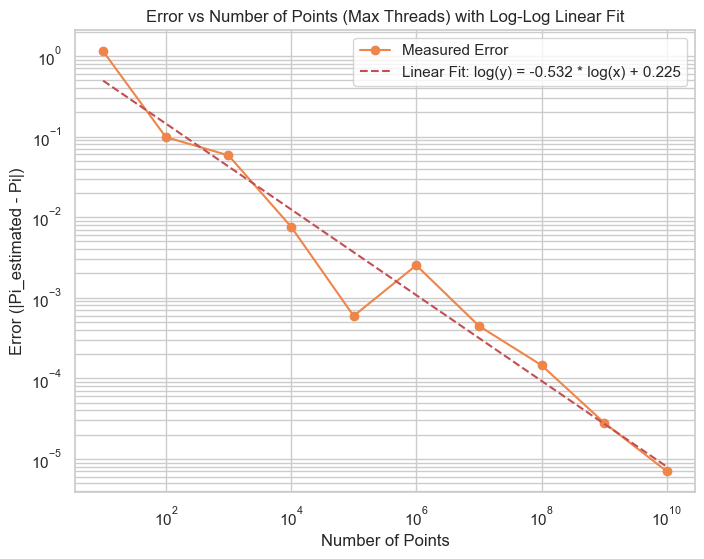

Linear Fit Equation: log(Error) = -0.532 * log(Points) + 0.225
R-squared: 0.9569


In [4]:
# Plot 2b: Error vs Number of Points (Max Threads) - Fitted Data

import numpy as np
from scipy.stats import linregress

# Apply log10 transformation to both points and max_threads_error
log_points = np.log10(points)
log_error = np.log10(max_threads_error)

# Perform a linear fit on the log-log data
slope, intercept, r_value, p_value, std_err = linregress(log_points, log_error)

# Generate the fitted values for the log of error using the linear fit
fitted_log_error = slope * log_points + intercept

# Convert back to linear space for plotting
fitted_error = 10**fitted_log_error

# Plot the original error data and the fitted linear curve in log-log space
plt.figure(figsize=(8, 6))
plt.plot(points, max_threads_error, marker='o', linestyle='-', color=colors[1], label='Measured Error')
plt.plot(points, fitted_error, linestyle='--', color='r', label=f'Linear Fit: log(y) = {slope:.3f} * log(x) + {intercept:.3f}')

# Set log scale for both axes
plt.xscale('log')
plt.yscale('log')

# Add labels, title, grid, and legend
plt.xlabel('Number of Points')
plt.ylabel('Error (|Pi_estimated - Pi|)')
plt.title('Error vs Number of Points (Max Threads) with Log-Log Linear Fit')
plt.grid(True, which='both', axis='both')
plt.minorticks_on()
plt.legend()

# Show the plot
plt.show()

# Print the linear fit equation and R-squared value
print(f"Linear Fit Equation: log(Error) = {slope:.3f} * log(Points) + {intercept:.3f}")
print(f"R-squared: {r_value**2:.4f}")

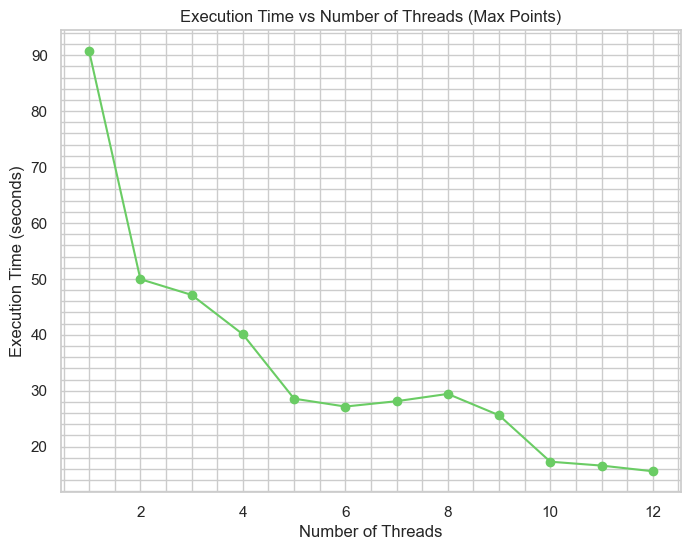

In [5]:
# Plot 3: Execution Time vs Number of Threads (Max Points)
max_points_exec_time = exec_times_df.iloc[-1, 1:]

plt.figure(figsize=(8, 6))
plt.plot(threads, max_points_exec_time, marker='o', linestyle='-', color=colors[2])
plt.xlabel('Number of Threads')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time vs Number of Threads (Max Points)')
plt.grid(True, which='both', axis='both')
plt.minorticks_on()
plt.show()

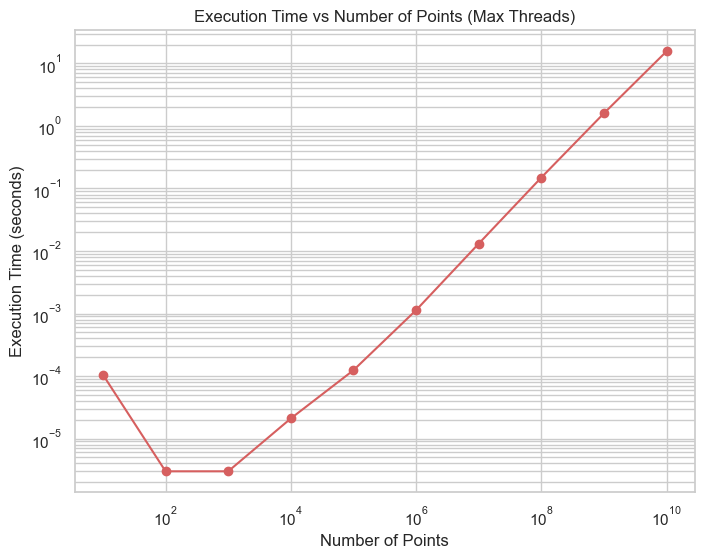

In [6]:
# Plot 4: Execution Time vs Number of Points (Max Threads)
max_threads_exec_time = exec_times_df[exec_times_df.columns[-1]]

plt.figure(figsize=(8, 6))
plt.plot(points, max_threads_exec_time, marker='o', linestyle='-', color=colors[3])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Points')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time vs Number of Points (Max Threads)')
plt.grid(True, which='both', axis='both')
plt.minorticks_on()
plt.show()

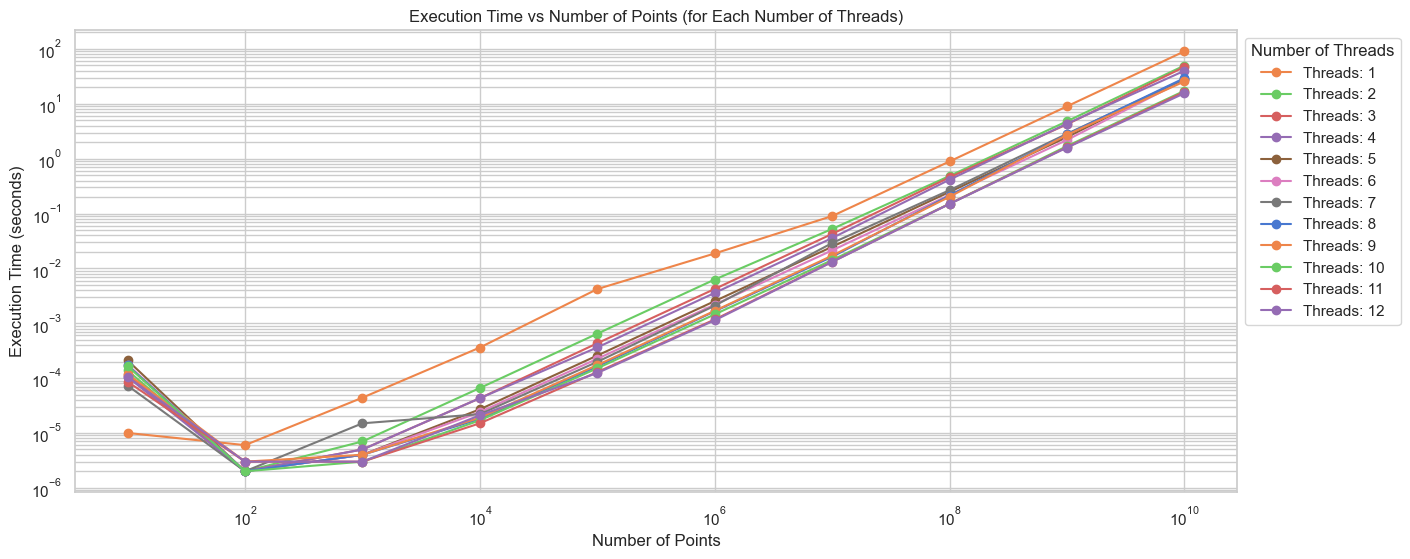

In [7]:
# Plot 5: Execution Time vs Number of Points (for Each Number of Threads)
plt.figure(figsize=(15, 6))

for i, col in enumerate(exec_times_df.columns[1:], start=1):
    plt.plot(points, exec_times_df[col], label=f'Threads: {i}', color=colors[i % len(colors)], linestyle='-', marker='o')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Points')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time vs Number of Points (for Each Number of Threads)')
plt.legend(title='Number of Threads', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, which='both', axis='both')
plt.minorticks_on()
plt.show()

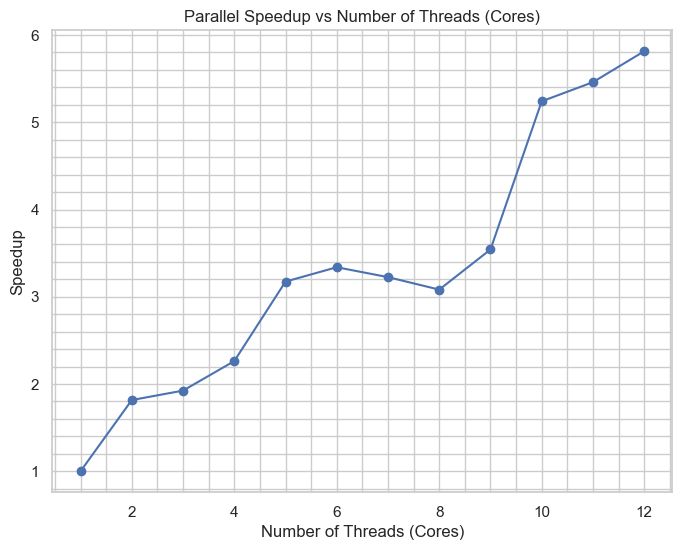

In [8]:
exec_time_single_thread = exec_times_df.iloc[-1, 1]       # Execution time for 1 thread, last simulation
exec_times_multiple_threads = exec_times_df.iloc[-1, 1:]  # Execution times for all threads, last simulation

# Calculate speedup
speedup = exec_time_single_thread / exec_times_multiple_threads

# Plot Speedup vs Number of Threads (Cores)
plt.figure(figsize=(8, 6))
plt.plot(threads, speedup, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Threads (Cores)')
plt.ylabel('Speedup')
plt.title('Parallel Speedup vs Number of Threads (Cores)')
plt.grid(True, which='both', axis='both')
plt.minorticks_on()
plt.show()

Fitted proportion p of parallelizable code: 0.8675


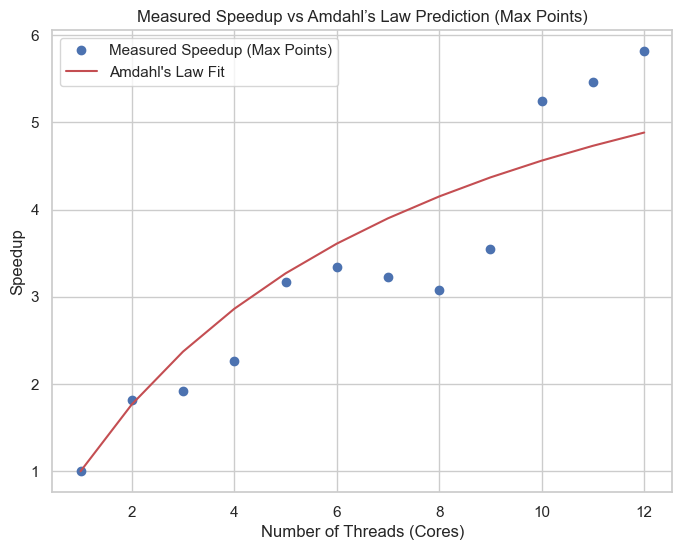

In [9]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Extract the last row from the execution times DataFrame (corresponding to the max points)
exec_times_max_points = exec_times_df.iloc[-1, 1:]  # Skip the "Points" column

# Compute speedup relative to the execution time with 1 thread (assumed to be the first column)
speedup_max_points = exec_times_max_points.iloc[0] / exec_times_max_points

# Define Amdahl's Law function for curve fitting
def amdahls_law(N, p):
    """
    Amdahl's Law function to compute speedup based on the number of threads (N)
    and the proportion of parallelizable code (p).
    """
    return 1 / ((1 - p) + p / N)

# Fit Amdahl's Law to the speedup data for the max points
popt, pcov = curve_fit(amdahls_law, threads, speedup_max_points)

# Extract the fitted value of p (the parallelizable portion)
p_fitted = popt[0]

# Print the fitted value of p
print(f"Fitted proportion p of parallelizable code: {p_fitted:.4f}")

# Generate predicted speedup values using the fitted value of p
predicted_speedup = amdahls_law(np.array(threads), p_fitted)

# Plot actual speedup vs Amdahl’s Law predicted speedup for the max points
plt.figure(figsize=(8, 6))
plt.plot(threads, speedup_max_points, 'o', label='Measured Speedup (Max Points)', color='b')
plt.plot(threads, predicted_speedup, '-', label="Amdahl's Law Fit", color='r')
plt.xlabel('Number of Threads (Cores)')
plt.ylabel('Speedup')
plt.title('Measured Speedup vs Amdahl’s Law Prediction (Max Points)')
plt.legend()
plt.grid(True, which='both')
plt.show()

In [10]:
# Calculate the speedup for 10,000 cores
max_cores = 10000
max_speedup = amdahls_law(max_cores, p_fitted)

# Print the maximum possible speedup for 10,000 cores
print(f"Maximum possible speedup with 10,000 cores: {max_speedup:.4f}")

Maximum possible speedup with 10,000 cores: 7.5399
